In [1]:
# 載入套件
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 以檔案目錄為基礎，建立訓練(Training)及驗證(Validation)資料集(Dataset)

In [3]:
image_size = (180, 180)  # 影像尺寸
batch_size = 32          # 批量

# 訓練資料集(Dataset)
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
# 加 color_mode="grayscale", 試試看
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './data/data/training_set',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
# 驗證(Validation)資料集
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './data/data/training_set',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5668 files belonging to 2 classes.
Using 4535 files for training.
Found 5668 files belonging to 2 classes.
Using 1133 files for validation.


## 顯示訓練資料前9筆影像

### 標注為1是狗(dog)，0是貓(cat)

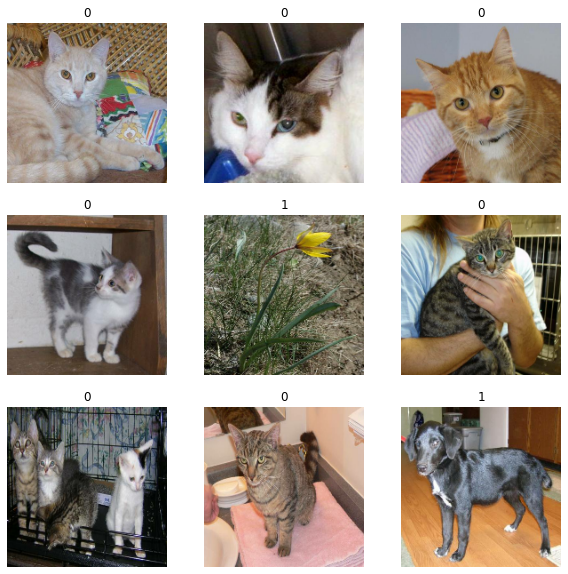

In [4]:
import matplotlib.pyplot as plt

# 顯示訓練資料前9筆影像
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## 定義資料增補(Data Augmentation)

In [5]:
# https://www.tensorflow.org/tutorials/images/data_augmentation
# RandomFlip("horizontal")：水平翻轉
# RandomRotation(0.1)：旋轉 0.1 比例 
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

## 顯示資料增補後的影像

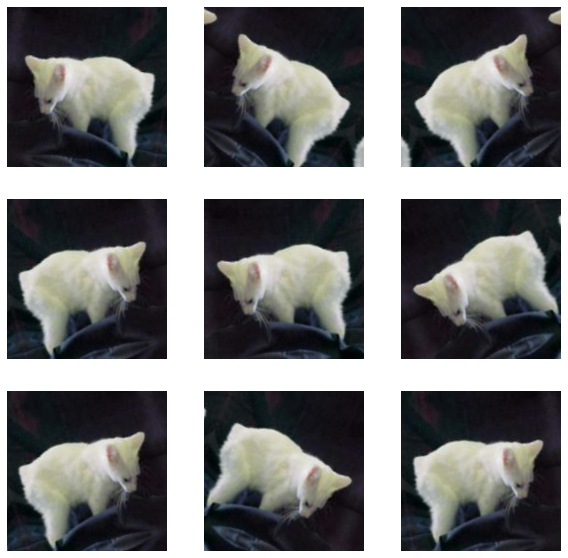

In [6]:
# 顯示資料增補後的影像
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## prefetch：預先讀取訓練資料，以提升效能

In [7]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## 建立模型

In [8]:
image_size + (3,)

(180, 180, 3)

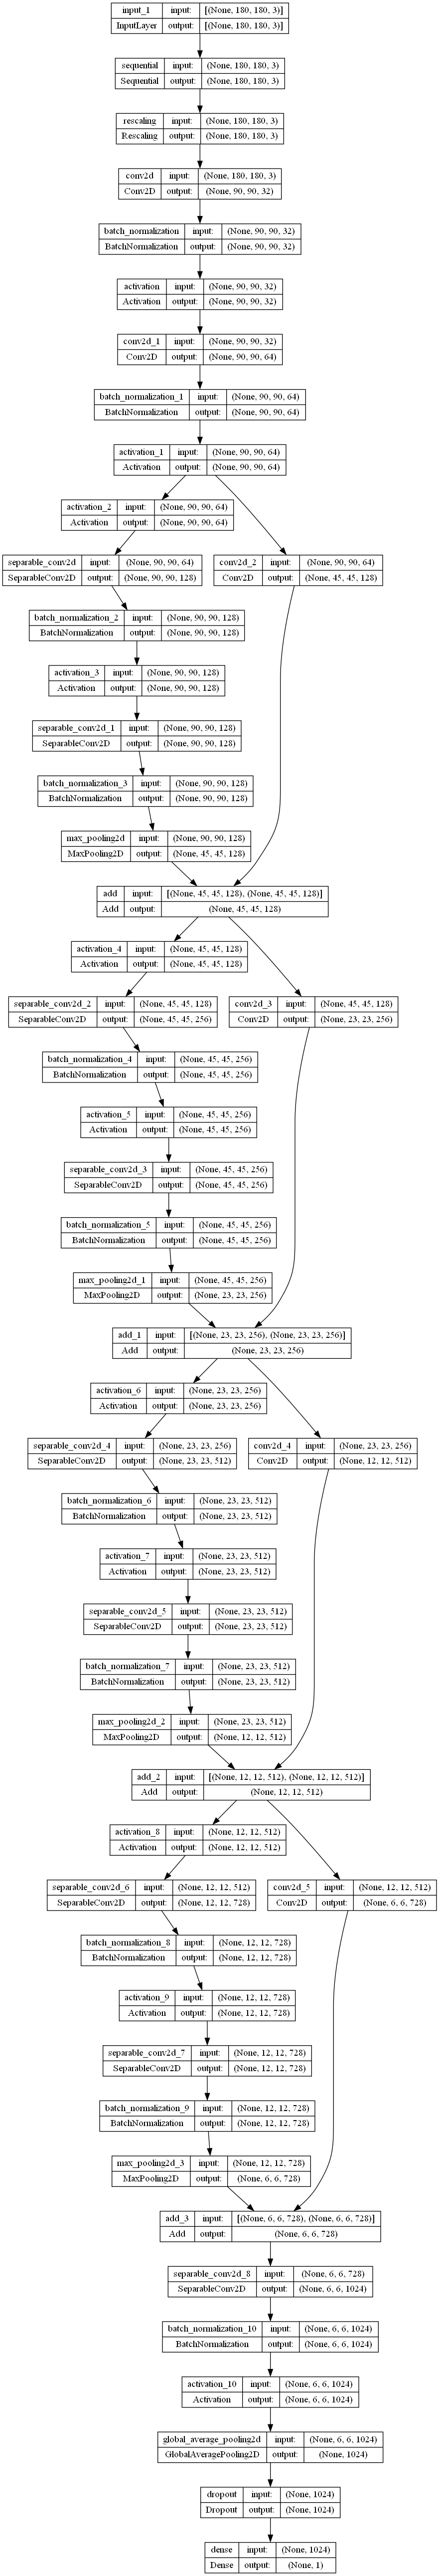

In [9]:
# 定義模型
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # 特徵縮放
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

# 建立模型
model = make_model(input_shape=image_size + (3,), num_classes=2)
# 繪製模型結構
keras.utils.plot_model(model, show_shapes=True)

## 訓練模型

In [10]:
epochs = 5

# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# 模型訓練
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds
)

Epoch 1/5
142/142 [==============================] - 853s 6s/step - loss: 0.4695 - accuracy: 0.8099 - val_loss: 0.7163 - val_accuracy: 0.7061
Epoch 2/5
142/142 [==============================] - 742s 5s/step - loss: 0.4123 - accuracy: 0.8295 - val_loss: 0.9008 - val_accuracy: 0.7061
Epoch 3/5
142/142 [==============================] - 720s 5s/step - loss: 0.3933 - accuracy: 0.8399 - val_loss: 1.0202 - val_accuracy: 0.7061
Epoch 4/5
142/142 [==============================] - 743s 5s/step - loss: 0.3749 - accuracy: 0.8467 - val_loss: 0.3930 - val_accuracy: 0.8429
Epoch 5/5
142/142 [==============================] - 732s 5s/step - loss: 0.3685 - accuracy: 0.8549 - val_loss: 0.6255 - val_accuracy: 0.7043


### 訓練 50 epochs，驗證準確率可達 96%.

In [11]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './data/data/test_set',
    image_size=image_size,
    batch_size=batch_size,
)

score = model.evaluate(test_ds, verbose=0)
print('\n', 'Test accuracy:', score[1])

Found 2665 files belonging to 2 classes.

 Test accuracy: 0.7523452043533325


## 從目錄中任選一個檔案測試

In [18]:
# 任取一筆資料測試
import os
img = keras.preprocessing.image.load_img(
    r"./data/data/test_set/notcats/dog.4006.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img) # 將影像轉為陣列
img_array = tf.expand_dims(img_array, 0)  # 增加一維在最前面，代表一筆資料

predictions = model.predict(img_array)
score = predictions[0][0]
print(f"是貓的機率= {(100 * score):.2f}%")

1/1 [==============================] - 0s 77ms/step
是貓的機率= 21.06%


In [20]:
img = keras.preprocessing.image.load_img(
    r"./data/data/test_set/cats/cat.4001.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img) # 將影像轉為陣列
img_array = tf.expand_dims(img_array, 0)  # 增加一維在最前面，代表一筆資料

predictions = model.predict(img_array)
score = predictions[0][0]
print(f"是貓的機率= {(100 * score):.2f}%")

1/1 [==============================] - 0s 82ms/step
是貓的機率= 84.45%


In [26]:
img = keras.preprocessing.image.load_img(
    r"./data/data/test_set/notcats/dog.4014.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img) # 將影像轉為陣列
img_array = tf.expand_dims(img_array, 0)  # 增加一維在最前面，代表一筆資料
#print(img_array.shape)
predictions = model.predict(img_array)
score = predictions[0][0]
print(f"是貓的機率= {(100 * score):.2f}%")

1/1 [==============================] - 0s 70ms/step
是貓的機率= 21.99%


(9, 180, 180, 3)

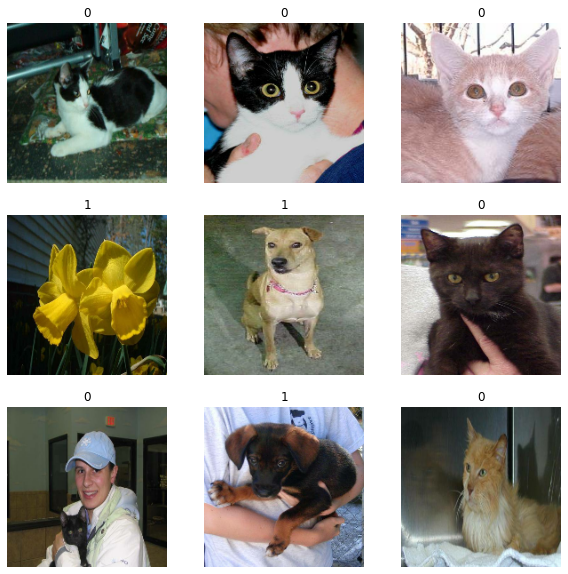

In [27]:
import numpy as np
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")    
        
        data = np.expand_dims(images[i].numpy().astype("uint8"),0)
        if i==0:
            test_images = data
            # print(test_images.shape)
        else:
            test_images = np.concatenate((test_images, data), axis=0)

test_images.shape

In [28]:
predictions = model.predict(test_images)
print(predictions)

1/1 [==============================] - 1s 884ms/step
[[0.9827093 ]
 [0.36353937]
 [0.56997484]
 [0.99992   ]
 [0.91313803]
 [0.06243062]
 [0.9623347 ]
 [0.23221274]
 [0.0774748 ]]


In [29]:
# 模型存檔
model.save('./pet_model')

INFO:tensorflow:Assets written to: ./pet_model\assets


INFO:tensorflow:Assets written to: ./pet_model\assets


In [31]:
# 模型載入
model = tf.keras.models.load_model('./pet_model')

In [32]:
#模型存檔(.h5)
model.save('./pet_model.h5')